# Research of flat announcements for sale
We have at our disposal data from the Yandex.Real Estate service - an archive of advertisements for flats for sale in St. Petersburg and neighbouring settlements for several years. We need to learn how to determine the market value of properties. Our task is to set the parameters. This will allow us to build an automated system: it will track anomalies and fraudulent activity.

For each flat for sale, two types of data are available. The first is entered by the user, the second is obtained automatically on the basis of map data. For example, the distance to the centre, airport, nearest park and water body.

In [106]:
# libraries import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# widening display and returning full TOC
from IPython.display import display, HTML
display(HTML("<style>.container { width:80%; align: left; }</style>"))
display(HTML("<style>#toc-wrapper{ position: relative; width: 20%; top: 130px; left: 0px; }</style>"))

## Open the data file and review the general information

### Let's open the file and display the descriptive information on the screen to understand what we are working with, what data the file stores:¶

In [2]:
realty = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
realty.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Let's also take a look at the overall histogram for all numeric columns in the table to visualise the data:

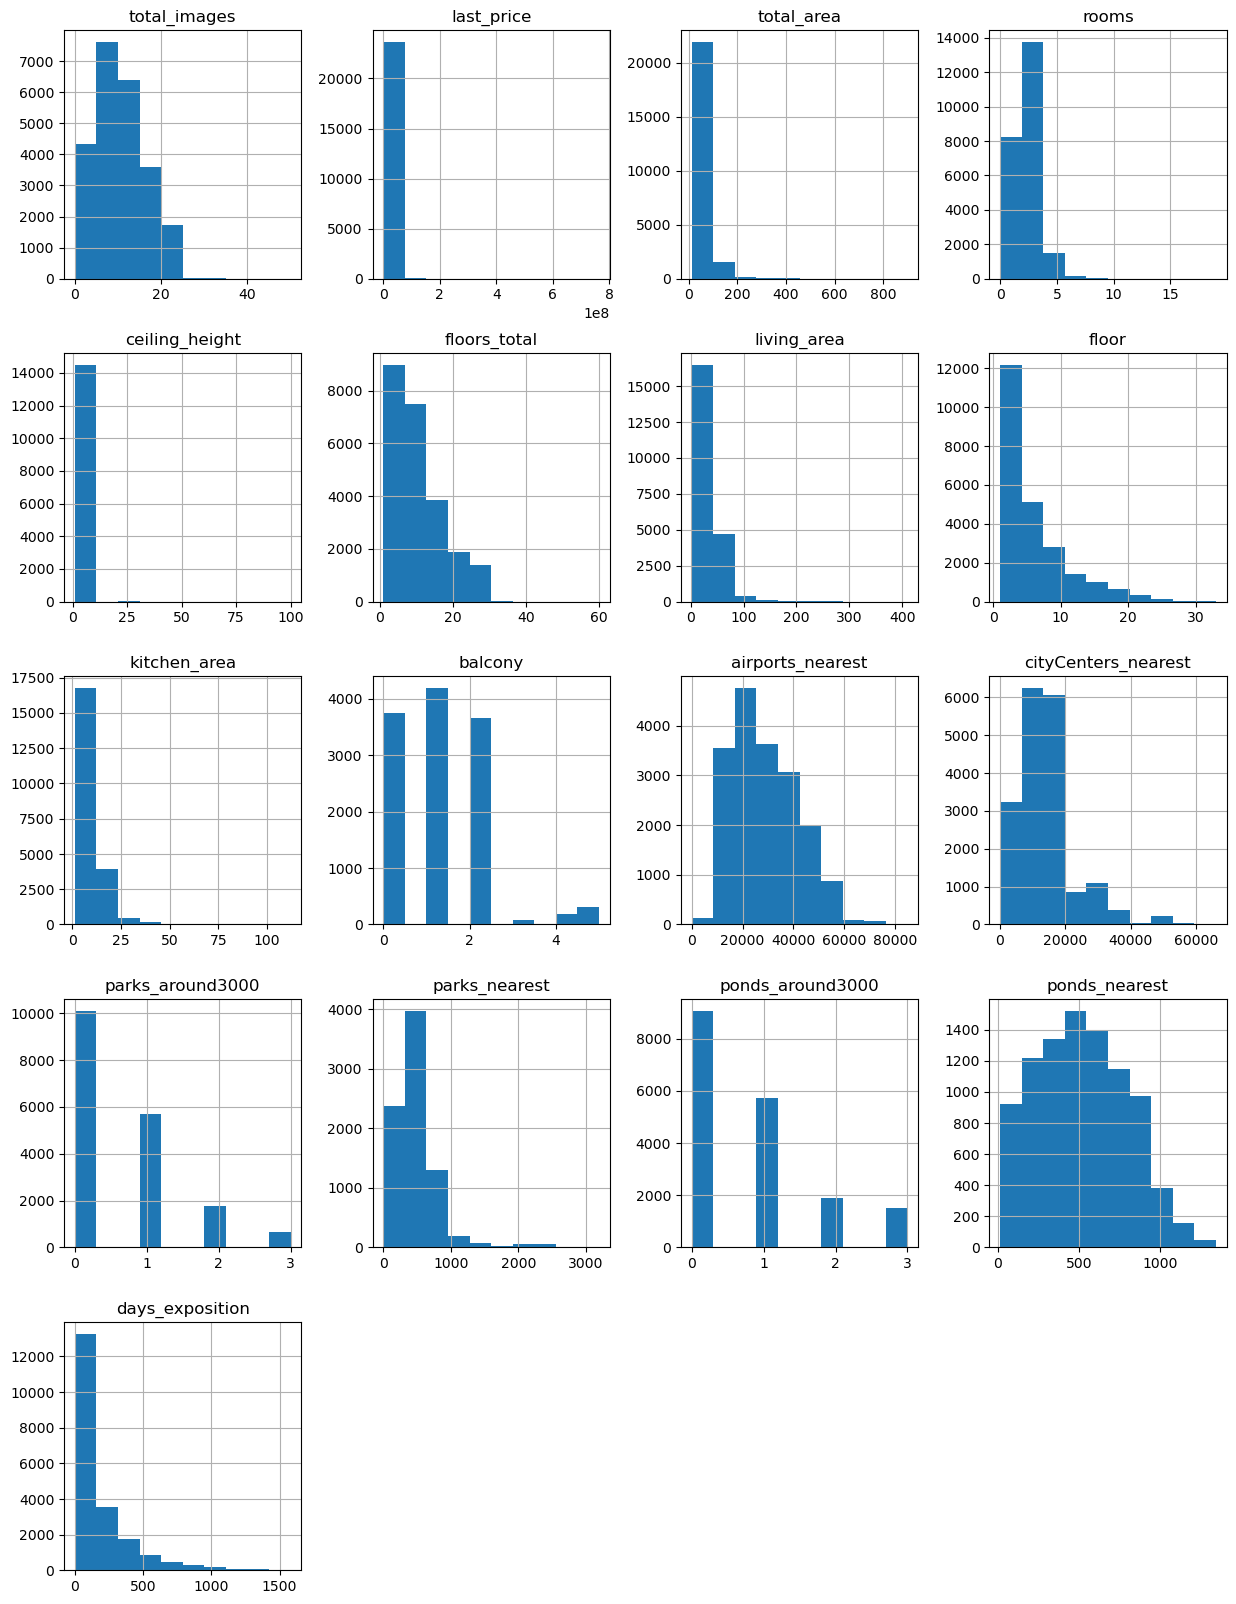

In [3]:
realty.hist(figsize=(15, 20));

### Summary:  
Opened a file and got basic information about it.

## Pre-processing

### Let's look at the technical information about the data in the table:

In [4]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
realty.shape[0]

23699

We see that there are 23699 rows in the table, some columns have missing values:  
- высота потолков (ceiling height),  
- количество этажей (number of floors),  
- жилая площадь (living area),  
- апартаменты (apartment) (булев тип/boolean type),  
- площадь кухни (kitchen area),  
- число балконов (balconies number),  
- наименование населённого пункта (locality name),  
- расстояние до ближаёшего аэропорта (distance to the nearest airport),  
- расстояние до центра города (distance to the city centre),  
- число парков в радиусе 3 км (number of parks within a 3 km radius),  
- расстроянние до ближайшего парка (distance to the nearest park),  
- число водоёмов в радиусе 3 км (number of water bodies within a 3 km radius),  
- расстояние до ближайшего водоёма (distance to the nearest water body),  
- длительность размещения объявления (duration of the announcement).

In [6]:
realty.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Generally, the table data is adequate, but of course there are some suspicious values, e.g.:  
- 100 meter ceiling heights,  
- more than 100 metre kitchens,  
- 900 metre flats,  
- 5 balconies.  
  
We have to check this. Also apparently a big difference between the mean and median in the column of the duration of the ad placement.

#### 100 meter ceiling heights:

In [7]:
realty.loc[realty['ceiling_height'] > 50]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


We see that this is not an informative line at all:  
- no photos,  
- apartment,  
- fifth floor in a five-storey building,  
- price 15 million for 25 metres.  

We can delete the line.

In [8]:
realty = realty.drop(index= 22869)

#### More than 100 meters kitchens:

In [9]:
realty['kitchen_area'].sort_values().unique()

array([  1.3 ,   2.  ,   2.3 ,   2.4 ,   2.89,   3.  ,   3.2 ,   3.3 ,
         3.4 ,   3.5 ,   3.7 ,   3.8 ,   4.  ,   4.1 ,   4.2 ,   4.3 ,
         4.4 ,   4.5 ,   4.6 ,   4.7 ,   4.8 ,   4.9 ,   5.  ,   5.04,
         5.06,   5.1 ,   5.14,   5.2 ,   5.21,   5.23,   5.25,   5.28,
         5.29,   5.3 ,   5.31,   5.33,   5.35,   5.4 ,   5.42,   5.44,
         5.47,   5.49,   5.5 ,   5.53,   5.59,   5.6 ,   5.61,   5.62,
         5.64,   5.65,   5.68,   5.7 ,   5.74,   5.75,   5.78,   5.8 ,
         5.82,   5.85,   5.86,   5.9 ,   5.91,   6.  ,   6.02,   6.03,
         6.1 ,   6.16,   6.19,   6.2 ,   6.22,   6.23,   6.24,   6.25,
         6.26,   6.27,   6.28,   6.3 ,   6.31,   6.33,   6.35,   6.36,
         6.37,   6.4 ,   6.47,   6.5 ,   6.55,   6.58,   6.6 ,   6.61,
         6.62,   6.65,   6.7 ,   6.72,   6.73,   6.76,   6.77,   6.8 ,
         6.82,   6.83,   6.84,   6.86,   6.9 ,   6.91,   6.93,   6.95,
         7.  ,   7.02,   7.03,   7.06,   7.09,   7.1 ,   7.12,   7.15,
      

In [10]:
realty_kitchen_100 = realty.loc[realty['kitchen_area'] > 70]
realty_kitchen_100[['last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'kitchen_area', 'is_apartment', 'days_exposition']].sort_values(by='kitchen_area', ascending=False)

#data.loc[data['Эксперимент'] == '+', 'Имя']
#df.loc[(df.some_column == 'filter'),].sort_values(by=['my_date'])

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,kitchen_area,is_apartment,days_exposition
19540,420000000.0,900.0,12,2.8,25.0,409.7,112.0,NaN,106.0
20215,85000000.0,249.7,3,NaN,10.0,72.0,107.0,NaN,26.0
2489,12500000.0,255.0,3,NaN,2.0,153.9,100.7,NaN,102.0
5358,65000000.0,590.0,15,3.5,6.0,409.0,100.0,NaN,14.0
16239,82400000.0,181.1,3,3.9,9.0,58.2,93.2,False,501.0
16797,65850000.0,146.0,2,NaN,9.0,40.0,93.0,NaN,77.0
10867,56844500.0,177.9,3,NaN,6.0,87.2,87.2,True,NaN
492,95000000.0,216.0,4,3.0,5.0,86.0,77.0,NaN,14.0
4394,57000000.0,174.0,3,3.2,10.0,95.0,77.0,NaN,1039.0
14644,47000000.0,150.0,4,3.7,6.0,58.0,75.0,NaN,507.0


The first, third and fourth lines look like advertisements for palaces, let them be.   
The second and all other lines look suspicious: the living area is less than the kitchen area, more likely it is a typo, the data is similar to the data of multi-room flats, except for the kitchen area.   
I would divide the value by 10 wherever the kitchen area is more than 50 m, as we know that the smallest kitchens are in Khrushchevka flats (5 m).

In [11]:
realty['kitchen_area'] = realty['kitchen_area'].apply(lambda x: x / 10 if (x > 50 and x < 100 or x==107.0) else x)

In [12]:
realty_kitchen_100 = realty.loc[realty['kitchen_area'] > 70]
realty_kitchen_100[['last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'kitchen_area', 'is_apartment', 'days_exposition']].sort_values(by='kitchen_area', ascending=False)


,last_price,total_area,rooms,ceiling_height,floors_total,living_area,kitchen_area,is_apartment,days_exposition
19540,420000000.0,900.0,12,2.8,25.0,409.7,112.0,NaN,106.0
2489,12500000.0,255.0,3,NaN,2.0,153.9,100.7,NaN,102.0
5358,65000000.0,590.0,15,3.5,6.0,409.0,100.0,NaN,14.0


#### Let's check the 900 meters flats:

In [13]:
realty.loc[realty['total_area'] > 500]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3117,19,140000000.0,631.0,2019-03-30T00:00:00,7,NaN,5.0,NaN,5,NaN,False,False,6.0,NaN,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
4237,1,50000000.0,517.0,2017-10-14T00:00:00,7,NaN,4.0,332.0,3,NaN,False,False,22.0,NaN,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.50,6.0,409.0,3,NaN,False,False,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
8018,20,84000000.0,507.0,2015-12-17T00:00:00,5,4.45,7.0,301.5,7,True,False,False,45.5,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
12859,20,140000000.0,631.2,2019-04-09T00:00:00,7,3.90,4.0,322.3,4,NaN,False,False,19.5,1.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
15651,20,300000000.0,618.0,2017-12-18T00:00:00,7,3.40,7.0,258.0,5,NaN,False,False,7.0,NaN,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.80,25.0,409.7,25,NaN,False,False,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Looks like some lost adverts for multi-storey houses/cottages, maybe commercial property. I'll leave it be.

In [14]:
# 4 and over balconies
len(realty.loc[realty['balcony'] >= 4])

486

The typos are beyond logic. Unless the adverts where they're selling multi storey buildings.

### Let's see which missing values we can do something about.

Let's create a function to see the percentage of Nan data in the column we are interested in:

In [15]:
def show_nan_data(column):
    print('{:.1%}'.format(realty[column].isna().value_counts() [1] / len(realty), 2) + ' values missed.')
    return

#### Ceiling height

In [16]:
show_nan_data('ceiling_height')

38.8% values missed.


In [17]:
realty['ceiling_height'].sort_values().unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.3 ,  2.34,  2.4 ,
        2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,  2.53,
        2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,  2.62,
        2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,  2.71,
        2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,  2.8 ,
        2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,  2.89,
        2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,  2.98,
        2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,  3.07,
        3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,  3.16,
        3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,  3.26,
        3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,
        3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,  3.45,
        3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,  3.54,
        3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,  3.65,
        3.66,  3.67,

A ceiling height of 2.4 metres is considered to be the minimum rule in Russia. In new buildings, this value is usually between 2.5 and 2.7 metres. For elite housing, the figure may exceed 3 metres. There is information that in St. Petersburg there are flats with different ceiling heights in different rooms of the same flat, and also in St. Petersburg old buildings one can meet flats in which the ceiling reaches 9 metres.

However, let's check the data on flats with unusually high ceilings by sorting the table by decreasing:

In [18]:
realty.sort_values('ceiling_height', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.0,6.0,55.5,5,False,False,False,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,False,False,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21377,19,4900000.0,42.0,2017-04-18T00:00:00,1,27.5,24.0,37.7,19,False,False,False,11.0,2.0,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
20478,11,8000000.0,45.0,2017-07-18T00:00:00,1,27.0,4.0,22.0,2,NaN,False,False,10.0,1.0,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,NaN,False,False,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
17857,1,3900000.0,56.0,2017-12-22T00:00:00,3,27.0,5.0,33.0,4,False,False,False,NaN,NaN,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,NaN,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
21824,20,2450000.0,44.0,2019-02-12T00:00:00,2,27.0,2.0,38.0,2,False,False,False,8.6,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,False,False,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
10773,8,3800000.0,58.0,2017-10-13T00:00:00,2,27.0,10.0,30.1,3,False,False,False,8.1,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0


It looks like the values from 24 to 32 metres are simply not separated by a comma. Ceilings of 10-23 metres are suspicious. It would be logical to replace the empty values with median values of ceilings in flats of the corresponding storey.

Let's look at the pivot table, where we can see the median ceiling heights depending on the storey.

In [19]:
ceiling_medians = realty.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count']
ceiling_medians.head(10)

,median,count
floors_total,,
1.0,2.80,10
2.0,2.70,215
3.0,2.80,399
4.0,3.00,789
5.0,2.55,3665
6.0,3.00,619
7.0,3.00,398
8.0,2.80,220
9.0,2.55,2557


Let's replace missing values of ceiling heights with median values (row with index [5] of the table describe) of ceiling heights of houses of the same storey (if storey is specified) and total median value, if storey is not specified, and check the number of missing values after replacement:

In [20]:
for floor in ceiling_medians.index:
    realty.loc[(realty['ceiling_height'].isna()) & (realty['floors_total'] == floor), 'ceiling_height'] = ceiling_medians.loc[floor, 'median']
#realty['ceiling_height'].isna().value_counts()

for floor in ceiling_medians.index:
    realty.loc[(realty['floors_total'].isna()) | ((realty['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)), 'ceiling_height'] = realty['ceiling_height'].describe()[5]
realty['ceiling_height'].isna().value_counts()

ceiling_height
False    23698
Name: count, dtype: int64

We filled in the blanks.

Correct incorrectly entered ceiling heights of 24-32 metres:

In [21]:
realty['ceiling_height'] = realty['ceiling_height'].apply(lambda x: x / 10.0 if x >= 24.0 and x <=35.0 else x)

realty.sort_values('ceiling_height', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20507,12,5950000.0,60.0,2018-02-19T00:00:00,2,22.60,14.0,35.0,11,NaN,False,False,13.0,1.0,Санкт-Петербург,27028.0,12570.0,0.0,NaN,0.0,NaN,40.0
17496,15,6700000.0,92.9,2019-02-19T00:00:00,3,20.00,17.0,53.2,14,NaN,False,False,12.0,5.0,Санкт-Петербург,16295.0,15092.0,1.0,967.0,0.0,NaN,NaN
397,15,5990000.0,54.0,2018-03-22T00:00:00,2,14.85,36.0,21.4,28,NaN,False,False,18.7,1.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0
15061,19,5600000.0,56.4,2018-05-11T00:00:00,2,14.00,14.0,32.4,5,NaN,False,False,9.1,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
22309,20,5300000.0,45.0,2017-09-30T00:00:00,1,10.30,16.0,15.5,15,NaN,False,False,NaN,NaN,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
5863,20,5650000.0,45.0,2018-08-15T00:00:00,1,8.30,16.0,19.3,14,NaN,False,False,8.3,1.0,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0
15743,14,5600000.0,67.0,2016-11-11T00:00:00,3,8.00,16.0,41.0,1,NaN,False,False,8.0,NaN,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
3474,3,1400000.0,30.0,2018-03-16T00:00:00,1,8.00,5.0,15.3,2,False,False,False,7.3,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
17442,0,5350000.0,54.0,2015-06-16T00:00:00,2,8.00,5.0,29.0,2,NaN,False,False,NaN,1.0,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0
20264,17,119000000.0,187.6,2017-07-10T00:00:00,4,6.00,7.0,147.0,7,NaN,False,False,15.6,NaN,Санкт-Петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0


#### Number of floors


In [22]:
show_nan_data('floors_total')

0.4% values missed.


It is not possible to fill in the missing data. However, there is not so much data, in this situation let's assume that they can be ignored, delete lines with missing number of floors from the dataframe:

In [23]:
realty.dropna(subset=['floors_total'], inplace=True)
realty['floors_total'].isna().value_counts()

floors_total
False    23612
Name: count, dtype: int64

#### Living area

In [24]:
show_nan_data('living_area')

7.9% values missed.


In [25]:
realty['living_area'].median() / realty['total_area'].median()

0.5769230769230769

It turns out that the median ratio of living area to total area is 0.58. By multiplying the total area by this ratio we can fill in the gaps in living space.

In [26]:
realty['living_area'].isna().value_counts()

living_area
False    21742
True      1870
Name: count, dtype: int64

Fill in the blanks in the living area using the ratio of median total area to living area:

In [27]:
realty['living_area'] = realty['total_area'].apply(lambda x: x*0.58 if x!=0 else x)

In [28]:
realty['living_area'].isna().value_counts()

living_area
False    23612
Name: count, dtype: int64

#### Apartments (boolean type)

In [29]:
show_nan_data('is_apartment')

11.7% values missed.


Nowadays the term "apartment" is on the radar, in adverts, advertisements and billboards, however, I can assume that I was just lucky enough to hear it and wonder what it is. It can be assumed that the average person does not know what it is, whether it applies to their flat, and in general rather does not think that anyone needs it. However, having filled cells in this column gives the impression that they were filled by people who know that their property is an apartment. There is also a possibility that the empty values are equal to is_apartment=False, but you can't say that with 100% certainty. 

#### Kitchen area

In [30]:
show_nan_data('kitchen_area')

9.4% values missed.


In [31]:
realty['kitchen_area'].sort_values().unique()

array([  1.3 ,   2.  ,   2.3 ,   2.4 ,   2.89,   3.  ,   3.2 ,   3.3 ,
         3.4 ,   3.5 ,   3.7 ,   3.8 ,   4.  ,   4.1 ,   4.2 ,   4.3 ,
         4.4 ,   4.5 ,   4.6 ,   4.7 ,   4.8 ,   4.9 ,   5.  ,   5.02,
         5.04,   5.06,   5.1 ,   5.14,   5.18,   5.2 ,   5.21,   5.23,
         5.25,   5.28,   5.29,   5.3 ,   5.31,   5.31,   5.33,   5.35,
         5.4 ,   5.42,   5.43,   5.44,   5.47,   5.49,   5.5 ,   5.53,
         5.55,   5.57,   5.59,   5.6 ,   5.61,   5.62,   5.64,   5.65,
         5.68,   5.7 ,   5.74,   5.75,   5.78,   5.8 ,   5.82,   5.84,
         5.85,   5.86,   5.9 ,   5.91,   6.  ,   6.02,   6.03,   6.1 ,
         6.16,   6.19,   6.2 ,   6.22,   6.23,   6.24,   6.25,   6.26,
         6.27,   6.28,   6.3 ,   6.31,   6.33,   6.34,   6.35,   6.36,
         6.37,   6.4 ,   6.47,   6.5 ,   6.55,   6.58,   6.6 ,   6.61,
         6.62,   6.65,   6.7 ,   6.72,   6.73,   6.76,   6.77,   6.8 ,
         6.82,   6.83,   6.84,   6.86,   6.9 ,   6.91,   6.93,   6.95,
      

In [32]:
realty.pivot_table(index='kitchen_area', values=['total_area', 'floors_total', 'cityCenters_nearest']).sort_values(by='kitchen_area', ascending=False).head(10)

,cityCenters_nearest,floors_total,total_area
kitchen_area,,,
112.0,7877.000000,25.000000,900.000000
100.7,6916.000000,2.000000,255.000000
100.0,4666.000000,6.000000,590.000000
50.0,7812.200000,9.333333,223.716667
49.4,8248.000000,17.000000,93.400000
49.2,6589.000000,8.000000,140.600000
48.5,11705.000000,3.000000,274.000000
48.3,2434.000000,5.000000,86.300000
48.0,10487.666667,14.000000,155.533333


The concept of "apartments" led me to think that the empty values in this column, as well as in the living area may be a consequence of the presence of the option "studio", and there is no way to specify what the kitchen area is. Well, and, of course, could be lazy vendors (for example, when the vendor is not the owner), well, or those who left it for later, and then did not come.
Also looked at what are these 50- and 100-metre kitchens: there is no clear understanding, it is both a 25-storey castle in the centre, and 5-storey palaces. Interesting)

In [33]:
len(realty.loc[(realty['studio'] == True) & (realty['kitchen_area'].isnull())])

146

Studios usually have kitchen area set as 0, so let's set 0.

In [34]:
#realty.loc[(realty[(realty['studio'] == True) & (realty['kitchen_area'].isnull())]), 'kitchen_area'] = 
#realty.loc[(realty[(realty['studio'] == True) & (realty['kitchen_area'].isnull())]), 'kitchen_area'].fillna(0, inplace=True)
#realty['kitchen_area'].isna().value_counts()


#### Balcony number

In [35]:
show_nan_data('balcony')

48.6% values missed.


In this point, definitely most of the blanks are due to the fact that in the absence of a balcony, the seller did not put in anything. Therefore, here I propose to replace the gaps with 0.

In [36]:
realty['balcony'].fillna(0, inplace=True)
realty['balcony'].isna().value_counts()

balcony
False    23612
Name: count, dtype: int64

#### Locality name

In [37]:
show_nan_data('locality_name')
realty['locality_name'].isna().value_counts()

0.2% values missed.


locality_name
False    23564
True        48
Name: count, dtype: int64

Minimum number of skips, I wonder how it is possible not to specify the locality in the advert for the sale of a flat? Most likely on the site of flat sales in St. Petersburg by default it is St. Petersburg (provided the distance to the centre is up to 10 km (I calculated the radius of Peter) and replaced it with St. Petersburg.

In [38]:
realty.loc[(realty['locality_name'].isna()) & (realty['cityCenters_nearest'] < 10000), 'locality_name'] = realty.loc[(realty['locality_name'].isna()) & (realty['cityCenters_nearest'] < 10000), 'locality_name'].fillna('Санкт-Петербург')
realty['locality_name'].isna().value_counts()

locality_name
False    23589
True        23
Name: count, dtype: int64

Let's look at unique values, adjust implicit duplicates, and make it a little prettier:

In [39]:
realty['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [40]:
len(realty['locality_name'].unique())

365

In [41]:
realty['locality_name'] = realty['locality_name'].replace('поселок Бугры', 'посёлок Бугры')
realty['locality_name'] = realty['locality_name'].replace('поселок Мурино', 'посёлок Мурино')
realty['locality_name'] = realty['locality_name'].replace('городской поселок Большая Ижора', 'городской посёлок Большая Ижора')
realty['locality_name'] = realty['locality_name'].replace('Кудрово', 'деревня Кудрово')
realty['locality_name'] = realty['locality_name'].replace('поселок городского типа Дубровка', 'посёлок городского типа Дубровка')
realty['locality_name'] = realty['locality_name'].replace('поселок городского типа имени Свердлова', 'посёлок городского типа имени Свердлова')
realty['locality_name'] = realty['locality_name'].replace('поселок городского типа Рябово', 'посёлок городского типа Рябово')
realty['locality_name'] = realty['locality_name'].replace('поселок Рябово', 'посёлок городского типа Рябово')

In [42]:
realty.dropna(subset=['locality_name'], inplace=True)
realty['locality_name'].isna().value_counts()

locality_name
False    23589
Name: count, dtype: int64

In [43]:
len(realty['locality_name'].unique())

358

Removed 6 implicit duplicates and corrected letters in a few places.

#### Distance to airport

In [44]:
show_nan_data('airports_nearest')

23.4% values missed.


This data is loaded based on map data. We need to hand over this information to the people in charge and let them check it. We will not use this data in this project, so we'll leave it.

#### Distance to city centre

In [45]:
show_nan_data('cityCenters_nearest')

23.3% values missed.


We don't really need these values, we just need to hand over this information to the person in charge/

#### Number of parks within a 3 km radius

In [46]:
show_nan_data('parks_around3000')

23.3% values missed.


In my opinion, this data is more complicated than the distance to the airport, because the number of airports can be counted usually with the fingers of one hand, and parks (squares) can be numerous. The data is machine entered, it is strange that there are blanks. We don't need this data in the research, but I would write to the colleagues responsible for this, pointing out where there are missing data, whether there is a dependence on the name of the locality.

#### Distance to the nearest park

In [47]:
show_nan_data('parks_nearest')

34.1% values missed.


#### Number of water bodies within 3 km

In [48]:
show_nan_data('ponds_around3000')

23.3% values missed.


#### Distance to the nearest water body

In [49]:
show_nan_data('ponds_nearest')

38.4% values missed.


I will put several items described above into one category (airports, parks, water bodies). We don't need these data for research, but we need to send information to our colleagues, where there are missing data, e.g. in connection with a locality.

#### Duration of the announcement

In [50]:
show_nan_data('days_exposition')

13.4% values missed.


The data is machine entered, there should be a counter on the site I guess. So the blanks says that the announcement is still active.

### Summary  
Found/counted missing values, replaced or removed where possible/necessary.

### Changing data types

#### Let's remember what data types we have in our columns and evaluate the need to change¶

In [51]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23589 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23589 non-null  int64  
 1   last_price            23589 non-null  float64
 2   total_area            23589 non-null  float64
 3   first_day_exposition  23589 non-null  object 
 4   rooms                 23589 non-null  int64  
 5   ceiling_height        23589 non-null  float64
 6   floors_total          23589 non-null  float64
 7   living_area           23589 non-null  float64
 8   floor                 23589 non-null  int64  
 9   is_apartment          2767 non-null   object 
 10  studio                23589 non-null  bool   
 11  open_plan             23589 non-null  bool   
 12  kitchen_area          21364 non-null  float64
 13  balcony               23589 non-null  float64
 14  locality_name         23589 non-null  object 
 15  airports_nearest      18

It is reasonable to change the data type in the following columns:

- price at the time of unpublishing to int (I have not met prices of flats with pennies),
- the date of publication should be a date, not a line,
- number of floors should be an integer,
- the apartment data should be a boolean value (like studio and open-plan), 
- the number of balconies should also be an integer,
- the number of balconies should also be an integer,
- the number of days of the announcement will be an integer.

#### Let's replace all floats with int at once through list creation:

In [52]:
float_to_int = ['last_price', 'floors_total', 'balcony', 'days_exposition']
for column in float_to_int:
    realty[column] = realty[realty[column].notna()][column].astype('int')

#### Поработаем с датой публикации:

Время не указано, потому оставим формат без времени:

In [53]:
realty['first_day_exposition'] = pd.to_datetime(realty['first_day_exposition'], format='ISO8601')

#### Make 'is_apartment' boolean:

There are a lot of Nan in the cell, so to change the type to boolean, all values must be filled. It is optimal not to delete a bunch of rows here, but to put False instead of Nan.

In [54]:
realty['is_apartment'] = realty['is_apartment'].fillna(False)
realty['is_apartment'].apply(lambda x: True if x == 'True' else False if x == 'False' else x)

#realty['is_apartment'] = realty['is_apartment'].replace({'True': True, 'False': False})
#realty['is_apartment'] = realty['is_apartment'].apply(lambda x:  {'True': True, 'False': False})
#(lambda x: x / 10.0 if x >= 24.0 and x <=35.0 else x)

0        False
1        False
2        False
3        False
4        False
         ...  
23694    False
23695    False
23696    False
23697    False
23698    False
Name: is_apartment, Length: 23589, dtype: bool

In [55]:
# change data type to save memory
float64_to_float32 = ['last_price', 'total_area', 'ceiling_height', 'living_area', 'kitchen_area', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']
for column in float64_to_float32:
    realty[column] = realty[realty[column].notna()][column].astype('float32')

### Checking the corrections:

In [56]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23589 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23589 non-null  int64         
 1   last_price            23589 non-null  float32       
 2   total_area            23589 non-null  float32       
 3   first_day_exposition  23589 non-null  datetime64[ns]
 4   rooms                 23589 non-null  int64         
 5   ceiling_height        23589 non-null  float32       
 6   floors_total          23589 non-null  int32         
 7   living_area           23589 non-null  float32       
 8   floor                 23589 non-null  int64         
 9   is_apartment          23589 non-null  bool          
 10  studio                23589 non-null  bool          
 11  open_plan             23589 non-null  bool          
 12  kitchen_area          21364 non-null  float32       
 13  balcony              

**Data types corrected successully**

### Let's look at the anomalies in the columns:

In [57]:
realty.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23589.000000,23589.0,23589.000000,23589,23589.000000,23589.000000,23589.000000,23589.000000,23589.000000,21364.000000,23589.000000,18065.000000,18088.000000,18089.000000,8044.000000,18089.000000,9049.000000,20418.000000
mean,9.877061,6541668.0,60.338512,2017-11-09 14:41:22.411293184,2.071347,2.711472,10.670524,34.996338,5.875620,10.445949,0.593158,28788.927734,14181.239258,0.611919,490.587891,0.769971,518.416626,180.894058
min,0.000000,12190.0,12.000000,2014-11-27 00:00:00,0.000000,1.000000,1.000000,6.960000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3400000.0,40.000000,2017-05-15 00:00:00,1.000000,2.550000,5.000000,23.200001,2.000000,7.000000,0.000000,18573.000000,9229.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4650000.0,52.000000,2017-12-12 00:00:00,2.000000,2.650000,9.000000,30.160000,4.000000,9.100000,0.000000,26736.000000,13089.500000,0.000000,455.000000,1.000000,503.000000,95.000000
75%,14.000000,6799000.0,69.750000,2018-08-26 00:00:00,3.000000,2.750000,16.000000,40.455002,8.000000,12.000000,1.000000,37250.000000,16280.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,763000000.0,900.000000,2019-05-03 00:00:00,19.000000,22.600000,60.000000,522.000000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000
std,5.680104,10906597.0,35.653660,NaN,1.078623,0.322535,6.593734,20.679029,4.870021,5.373302,0.960173,12627.875000,8613.826172,0.802269,341.345398,0.939163,277.934326,219.757675


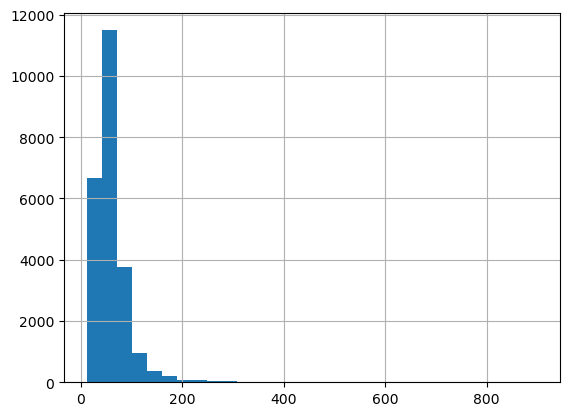

In [58]:
# let's check abnormal values 
data2 = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
(data2['total_area']).hist(bins=30);

We see that the flats over 200 m2 of living area are almost invisible, so we can drop them/

In [59]:
realty.drop(realty[realty.total_area > 200].index, inplace=True)

In [60]:
realty.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23363.000000,23363.0,23363.000000,23363,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,21167.000000,23363.000000,17846.000000,17866.000000,17867.000000,7896.000000,17867.000000,8890.000000,20244.000000
mean,9.852502,6025468.5,58.169018,2017-11-10 22:57:55.957711104,2.035312,2.706717,10.711296,33.738029,5.884989,10.304882,0.595129,28817.117188,14269.880859,0.603907,491.789642,0.762915,520.507629,179.722580
min,0.000000,12190.0,12.000000,2014-11-27 00:00:00,0.000000,1.000000,1.000000,6.960000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3400000.0,40.000000,2017-05-16 00:00:00,1.000000,2.550000,5.000000,23.200001,2.000000,7.000000,0.000000,18500.000000,9410.000000,0.000000,288.000000,0.000000,297.000000,45.000000
50%,9.000000,4600000.0,51.799999,2017-12-13 00:00:00,2.000000,2.650000,9.000000,30.044001,4.000000,9.000000,0.000000,26801.000000,13148.000000,0.000000,456.000000,0.000000,505.000000,95.000000
75%,14.000000,6700000.0,68.889999,2018-08-27 00:00:00,3.000000,2.750000,16.000000,39.956202,8.000000,11.900000,1.000000,37334.750000,16299.750000,1.000000,613.000000,1.000000,733.000000,230.000000
max,50.000000,330000000.0,200.000000,2019-05-03 00:00:00,11.000000,22.600000,60.000000,116.000000,33.000000,50.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000
std,5.665450,6246242.5,26.520058,NaN,0.995665,0.315966,6.602208,15.381832,4.879184,5.002560,0.960822,12673.762695,8599.784180,0.794350,342.040497,0.934812,277.818146,218.350845


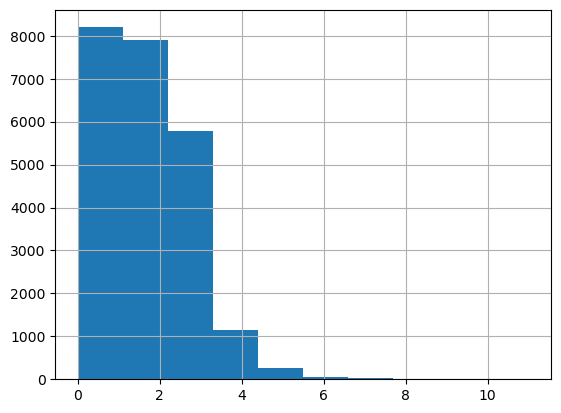

In [61]:
realty['rooms'].hist();

In [62]:
realty_rooms_5 = realty.loc[realty['rooms'] > 5]
realty_rooms_5[['last_price', 'total_area', 'rooms', 'floors_total', 'living_area']].sort_values(by='rooms', ascending=False)

,last_price,total_area,rooms,floors_total,living_area
648,17500000.0,183.699997,11,7,106.545998
9688,33000000.0,194.100006,11,5,112.578003
8758,16100000.0,150.000000,8,5,87.000000
4435,22190000.0,191.199997,8,6,110.896004
23555,15350000.0,158.500000,7,7,91.930000
...,...,...,...,...,...
12487,11970000.0,120.599998,6,6,69.947998
12549,14500000.0,165.000000,6,6,95.699997
12811,20000000.0,128.000000,6,5,74.239998
13082,23000000.0,150.000000,6,5,87.000000


I looked on the internet, flats of 4-5 rooms cost more than 50 million roubles. And here there are more than 5 rooms for 15 million roubles in 5-storey buildings. And 7 rooms in 100 square metres. Obviously some suspicious adverts, let's delete them.

In [63]:
realty.drop(realty[(realty['rooms'] > 5) & ((realty['last_price'] < 50000000) | (realty['floors_total'] == 5))].index, inplace=True)

Removed all announcements where (rooms more than 5) and ((price less than 50 million rubles) or (5-storey)).

In [64]:
realty_last_price_200m = realty.loc[realty['last_price'] > 200000000]
realty_last_price_200m[['last_price', 'total_area', 'kitchen_area', 'cityCenters_nearest', 'rooms', 'floors_total', 'living_area']].sort_values(by='last_price', ascending=False)

,last_price,total_area,kitchen_area,cityCenters_nearest,rooms,floors_total,living_area
1436,330000000.0,190.0,40.000000,1197.0,3,7,110.199997
22831,289238400.0,187.5,30.200001,1073.0,2,6,108.750000


Let's drop such a pricey flats, even if they are located in the city center.

In [65]:
realty.drop(realty[realty.last_price > 200000000].index, inplace=True)

In [66]:
realty_last_price_200m = realty.loc[realty['last_price'] > 200000000]
realty_last_price_200m[['last_price', 'total_area', 'kitchen_area', 'cityCenters_nearest', 'rooms', 'floors_total', 'living_area']].sort_values(by='last_price', ascending=False)

,last_price,total_area,kitchen_area,cityCenters_nearest,rooms,floors_total,living_area


 ## Let's add new columns to the table¶

###  For the purposes of the study, we will add the following columns:¶
- price per square metre,
- day of the week of the advert publication (0 - Monday, 1 - Tuesday and so on),
- month of the ad's publication,
- year of publication of the advert,
- type of flat floor (values - "first", "last", "other"),
- distance to the city centre in kilometres (convert from m to km and round up to whole values).

#### Price per square metre

In [67]:
realty['square_meter_price'] = realty['last_price'] / realty['total_area']
realty['square_meter_price'] = realty['square_meter_price'].astype('int')
for price in realty['square_meter_price']:
    print('%.0f' % price)

120370
82920
92785
408176
100000
95065
99195
110544
87454
88524
127525
75000
72037
82943
122222
119230
81707
116111
104838
117355
76500
101265
86206
92187
66872
89473
67500
101428
94772
86000
67073
106038
83166
65753
99696
104026
84222
43449
78750
95588
99722
106756
135970
194375
133750
102766
126679
64171
106414
99025
93360
279503
109974
90958
125850
106097
71111
118181
135483
78285
107972
61068
169491
69977
77192
101470
82258
56081
79092
113333
84347
81818
64363
69117
112500
50816
69243
117567
46499
51201
161014
55900
101449
54669
112311
71428
96134
51359
39682
95273
39444
58333
86633
118644
109574
112132
33547
146250
106666
98445
81081
112121
137142
89378
153125
84609
108910
118625
119961
53250
114750
75075
73717
186915
91666
113158
100590
145161
92537
80906
183333
35000
89583
142255
72837
79411
112909
80645
100000
54081
47819
81787
101612
112759
83125
125482
156413
120000
70967
160000
199386
53596
99666
90740
107662
82089
154231
134929
100000
86666
65701
99606
79090
102500
137375
9

#### Day of the week of the announcement publication

In [68]:
realty['publication_weekday_number'] = realty['first_day_exposition'].dt.weekday
realty['publication_weekday_number']

0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: publication_weekday_number, Length: 23276, dtype: int32

#### Month of the announcement publication

In [69]:
realty['publication_month'] = realty['first_day_exposition'].apply(lambda x: x.month)
realty['publication_month']

0         3
1        12
2         8
3         7
4         6
         ..
23694     3
23695     1
23696     2
23697     3
23698     7
Name: publication_month, Length: 23276, dtype: int64

#### Year of the announcement publication

In [70]:
realty['publication_year'] = realty['first_day_exposition'].apply(lambda x: x.year)
realty['publication_year']

0        2019
1        2018
2        2015
3        2015
4        2018
         ... 
23694    2017
23695    2018
23696    2018
23697    2017
23698    2017
Name: publication_year, Length: 23276, dtype: int64

#### Type of flat floor

In [71]:
import numpy as np
realty['floor_type'] = np.where(realty['floor'] == 1, 'первый', 'другой')
realty['floor_type'] = np.where(realty['floor'] == realty['floors_total'], 'последний', realty['floor_type'])
realty['floor_type']

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23694    другой
23695    другой
23696    первый
23697    другой
23698    первый
Name: floor_type, Length: 23276, dtype: object

#### Distance to the city centre in kilometres 

In [72]:
realty['distance_to_centre_km'] = realty['cityCenters_nearest'] / 1000
for km in realty['distance_to_centre_km']:
    print('%.0f' % km)

16
19
14
7
8
nan
19
12
nan
15
14
52
nan
33
31
14
11
15
11
13
19
10
nan
14
2
15
11
11
31
12
nan
13
13
32
13
4
16
nan
nan
12
19
13
31
11
12
13
13
nan
17
17
30
7
19
14
12
10
19
16
15
nan
4
nan
5
nan
10
nan
51
nan
nan
8
12
50
24
33
15
nan
16
14
nan
nan
nan
18
19
nan
9
28
15
nan
nan
14
nan
nan
12
7
14
16
nan
9
3
13
nan
16
10
11
16
6
33
10
27
nan
6
nan
19
6
9
21
10
9
12
51
4
nan
16
14
17
33
12
52
16
nan
nan
49
nan
15
35
4
4
3
nan
27
5
nan
6
nan
7
36
4
12
12
9
nan
17
34
3
15
14
nan
5
30
13
17
15
nan
36
nan
18
nan
15
nan
24
nan
13
nan
nan
12
8
14
3
11
3
30
33
15
9
14
17
12
16
17
nan
8
15
17
16
nan
nan
nan
52
14
16
50
33
7
2
nan
15
30
14
13
1
12
nan
12
16
13
5
16
32
11
nan
nan
nan
2
nan
nan
11
24
13
12
12
6
31
16
12
2
14
12
13
nan
10
13
12
nan
9
29
nan
nan
9
26
16
nan
16
nan
nan
nan
11
nan
5
7
nan
nan
15
10
nan
14
14
nan
18
16
24
24
5
15
9
12
17
nan
2
nan
32
10
nan
35
15
17
34
4
nan
nan
11
nan
nan
15
nan
16
11
31
53
33
15
4
nan
15
31
9
21
16
16
nan
9
4
3
10
5
16
5
34
nan
5
22
11
16
15
15
12
2
3

In [73]:
realty

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,publication_weekday_number,publication_month,publication_year,floor_type,distance_to_centre_km
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16,62.639999,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой,16.028000
1,7,3350000.0,40.400002,2018-12-04,1,2.75,11,23.431999,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый,18.603001
2,10,5196000.0,56.000000,2015-08-20,2,2.55,5,32.480000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой,13.933000
3,0,64900000.0,159.000000,2015-07-24,3,2.60,14,92.220001,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015,другой,6.800000
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14,58.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой,8.098000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.809998,2017-03-21,3,3.70,5,77.609802,3,False,False,False,13.830000,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,72490,1,3,2017,другой,4.232000
23695,14,3100000.0,59.000000,2018-01-15,3,2.55,5,34.220001,4,False,False,False,8.500000,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,52542,0,1,2018,другой,NaN
23696,18,2500000.0,56.700001,2018-02-11,2,2.80,3,32.886002,1,False,False,False,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44091,6,2,2018,первый,NaN
23697,13,11475000.0,76.750000,2017-03-28,2,3.00,17,44.514999,12,False,False,False,23.299999,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,149511,1,3,2017,другой,10.364000


### Summary:  
We see that the columns are in place.

## Exploratory data analysis

### Task:  
To study the following parameters of the facilities:
- total floor area,
- living area,
- kitchen area,
- price of the object,
- number of rooms,
- ceiling height,
- floor of the flat,
- type of flat floor ("first", "last", "other"),
- total number of floors in the building,
- distance to the city centre in metres,
- distance to the nearest airport,
- distance to the nearest park,
- day and month of the advert publication.
 
Create separate visualizations for each of these parameters. Describe observations on the parameters.

#### Let's look at the main characteristics of these specified parameters:

In [74]:
realty[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floor', 'floor_type', 'floors_total', 'cityCenters_nearest', 'airports_nearest', 'parks_nearest', 'publication_weekday_number', 'publication_month']].describe()

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,floors_total,cityCenters_nearest,airports_nearest,parks_nearest,publication_weekday_number,publication_month
count,23276.000000,23276.000000,21087.000000,23276.0,23276.000000,23276.000000,23276.000000,23276.000000,17782.000000,17762.000000,7835.000000,23276.000000,23276.000000
mean,57.801876,33.525089,10.282082,5958050.5,2.019333,2.705346,5.893152,10.729034,14313.312500,28840.023438,492.297119,2.566549,6.404451
std,25.819941,14.975625,4.982358,5514750.5,0.960426,0.315003,4.883446,6.605651,8588.529297,12693.577148,343.008209,1.789598,3.493646
min,12.000000,6.960000,1.300000,12190.0,0.000000,1.000000,1.000000,1.000000,181.000000,0.000000,1.000000,0.000000,1.000000
25%,40.000000,23.200001,7.000000,3400000.0,1.000000,2.550000,2.000000,5.000000,9487.000000,18488.500000,288.000000,1.000000,3.000000
50%,51.500000,29.870001,9.000000,4600000.0,2.000000,2.650000,4.000000,9.000000,13168.000000,26890.000000,456.000000,3.000000,6.000000
75%,68.300003,39.613998,11.800000,6650000.0,3.000000,2.750000,8.000000,16.000000,16324.250000,37406.750000,614.000000,4.000000,10.000000
max,200.000000,116.000000,50.000000,135000000.0,5.000000,22.600000,33.000000,60.000000,65968.000000,84869.000000,3190.000000,6.000000,12.000000


The numbers are pretty smooth because we've removed any anomalies: 
- there is a wide range of areas, from 12 to 200 square metres, to suit all tastes,
- kitchen area is more or less normal, average 9 metres,
- rooms from 0 (studio) to 5, on average, 2,
- average ceiling height 2.65 metres,
- floors from 1 to 33, median 4,
- most announcements in 9-storey buildings,
- most flat for sale ads 13 km away from the centre and almost 27 from the airport,
- parks within walking distance in many announcements,
- most announcements are posted in the middle of the week and in June.

#### We'll examine all indicators in diagram charts. A convenient method for viewing distributions with one condition.

##### Plot the histogram for the total area:

,total_area
count,23276.000000
mean,57.801876
std,25.819941
min,12.000000
25%,40.000000
50%,51.500000
75%,68.300003
max,200.000000


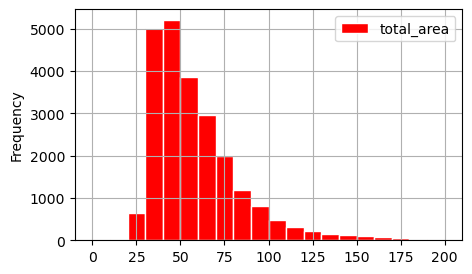

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

realty.plot(y='total_area', kind='hist', bins=20, grid=True, figsize=(5, 3), range= (0, 200), color='red', ec='white')
realty['total_area'].describe().to_frame()

The distribution of the data is normal, outliers are visible, but they are acceptable, this happens in palaces.

##### Let's also take a look at the graph for the living area:

,living_area
count,23276.000000
mean,33.525089
std,14.975625
min,6.960000
25%,23.200001
50%,29.870001
75%,39.613998
max,116.000000


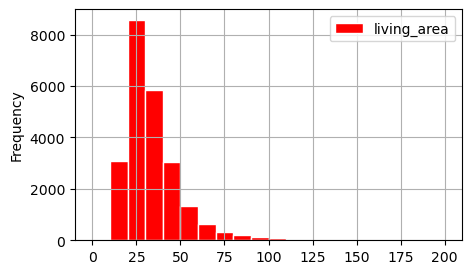

In [76]:
realty.plot(y='living_area', kind='hist', bins=20, grid=True, figsize=(5, 3), range= (0, 200), color='red', ec='white')
realty['living_area'].describe().to_frame()

##### And kitchen area:

,kitchen_area
count,21087.000000
mean,10.282082
std,4.982358
min,1.300000
25%,7.000000
50%,9.000000
75%,11.800000
max,50.000000


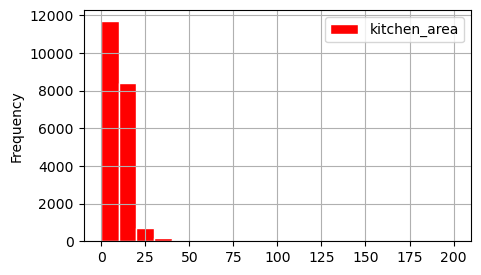

In [77]:
realty.plot(y='kitchen_area', kind='hist', bins=20, grid=True, figsize=(5, 3), range= (0, 200), color='red', ec='white')
realty['kitchen_area'].describe().to_frame()

We see proportional dependence, everything is fine.

*I made the range the same everywhere to show the dependence of the kitchen area on the total and living areas.

##### Let's take a look at the histogram of object prices, bringing the exponential record into a familiar one, for this purpose we translate the price into million rubles:

,last_price
count,23276.000000
mean,5.958051
std,5.514729
min,0.012190
25%,3.400000
50%,4.600000
75%,6.650000
max,135.000000


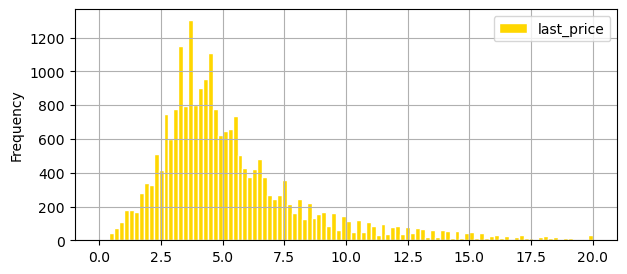

In [78]:
realty['last_price'] = realty['last_price'] / 1000000
realty.plot(y='last_price', kind='hist', bins=100, grid=True, range=(0, 20), figsize=(7,3), color='gold', ec='white')
realty['last_price'].describe().to_frame()

We see normal distribution, medians, minimum and maximum.

##### Let's build a histogram of the number of rooms:

,rooms
count,23276.000000
mean,2.019333
std,0.960426
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


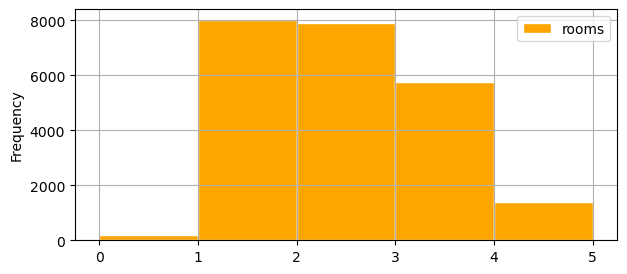

In [79]:
realty.plot(y='rooms', kind='hist', bins=5, grid=True, range=(0, 5), figsize=(7, 3), color='orange', ec='white')
realty['rooms'].describe().to_frame()

It's ok, lots of studios and 2-3 room flats. Less flats with 4-5 rooms.

##### Let's look at the distribution of ceiling heights on the histogram

,ceiling_height
count,23276.000000
mean,2.705346
std,0.315003
min,1.000000
25%,2.550000
50%,2.650000
75%,2.750000
max,22.600000


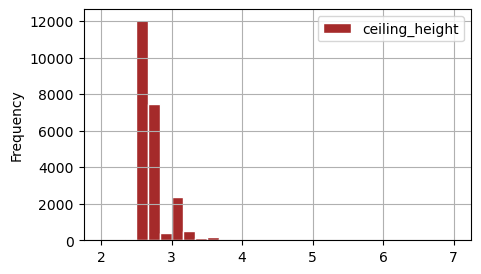

In [80]:
realty.plot(y='ceiling_height', kind='hist', bins=30, grid=True, range=(2, 7), figsize=(5, 3), color='brown', ec='white')
realty['ceiling_height'].describe().to_frame()

We see ceiling height from 1 to 22 m, in fact we realise that in reality a significant majority of them do not reach 4 metres. 2.65 average.

##### Floors histogram:

,floor
count,23276.000000
mean,5.893152
std,4.883446
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,33.000000


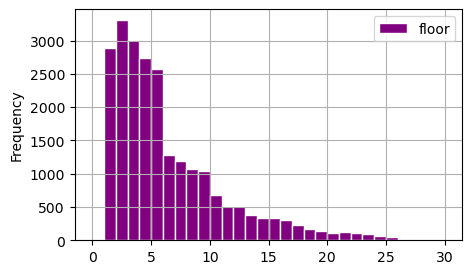

In [81]:
realty.plot(y='floor', kind='hist', bins=30, grid=True, range=(0, 30), figsize=(5, 3), color='purple', ec='white')
realty['floor'].describe().to_frame()

The main mass - flats on the 1st-6th floors. We also see an inversely proportional reduction in offers of flats on higher floors.

##### Let's look at the graph of the floor type in the advertisements:

The values are not numeric, so let's start by counting the number of floor types:

,floor_type
count,23276
unique,3
top,другой
freq,17149


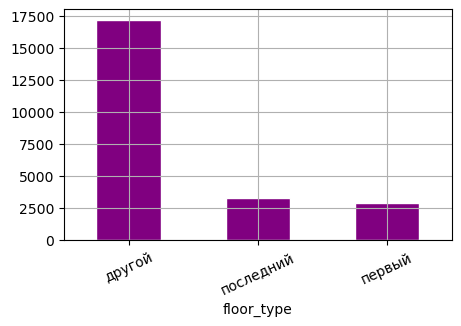

In [82]:
floor_type = realty['floor_type'].value_counts()
floor_type.plot(y='floor_type', kind='bar', grid=True, figsize=(5, 3), color='purple', ec='white')
plt.xticks(rotation=25)
realty['floor_type'].describe().to_frame()

The 'other' are the most frequent, the first and the last are approximately equal. However, this is not as indicative, as the 'other' category contains a large number of floors inside.

##### Graph for viewing information about the total number of floors in the house:

,floors_total
count,23276.000000
mean,10.729034
std,6.605651
min,1.000000
25%,5.000000
50%,9.000000
75%,16.000000
max,60.000000


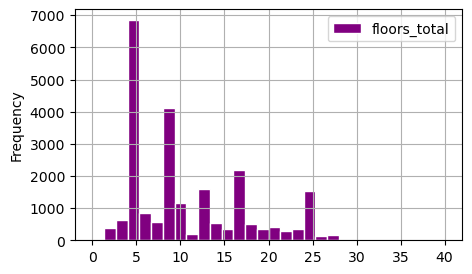

In [83]:
realty.plot(y='floors_total', kind='hist', bins=30, grid=True, range=(0, 40), figsize=(5, 3), color='purple', ec='white')
realty['floors_total'].describe().to_frame()

Most of all 5-storey buildings, fewer 9-storey buildings, 16-storey buildings and even 24-storey buildings.

##### Let's take a look at the distance to the city centre in metres on the histogram

,cityCenters_nearest
count,17782.000000
mean,14313.312500
std,8588.529297
min,181.000000
25%,9487.000000
50%,13168.000000
75%,16324.250000
max,65968.000000


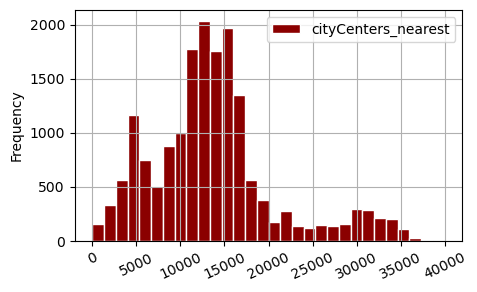

In [84]:
realty.plot(y='cityCenters_nearest', kind='hist', bins=30, grid=True, range=(0, 40000), figsize=(5, 3), color='darkred', ec='white')
plt.xticks(rotation=25)
realty['cityCenters_nearest'].describe().to_frame()

The chart shows that the most flats for sale are located within a radius of 10-17 km from the centre of St. Petersburg. There are also quite a few within a radius of 5 km, the rest in a range from 0 to 37 km

##### Distance to the nearest airport

,airports_nearest
count,17762.000000
mean,28840.023438
std,12693.577148
min,0.000000
25%,18488.500000
50%,26890.000000
75%,37406.750000
max,84869.000000


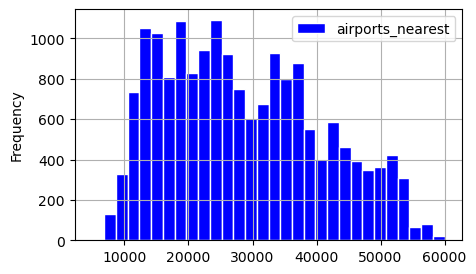

In [85]:
realty.plot(y='airports_nearest', kind='hist', bins=30, grid=True, range=(5000, 60000), figsize=(5, 3), color='blue', ec='white')
realty['airports_nearest'].describe().to_frame()

It clearly comes out that a lot of flats can be purchased within a 12-27 km radius, the total range is 0-85 km.

##### Distance to the nearest park

,parks_nearest
count,7835.000000
mean,492.297119
std,343.008209
min,1.000000
25%,288.000000
50%,456.000000
75%,614.000000
max,3190.000000


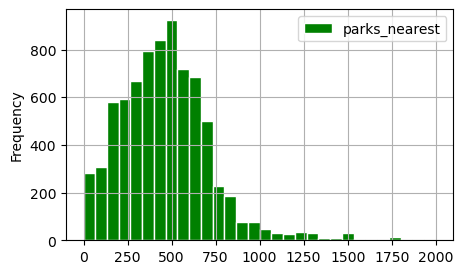

In [86]:
realty.plot(y='parks_nearest', kind='hist', bins=30, grid=True, range=(0, 2000), figsize=(5, 3), color='green', ec='white')
realty['parks_nearest'].describe().to_frame()

We know that parks can be found at a distance of 1m-3km, the average distance to the nearest park is plus or minus 500 m.

##### Publication weekday

,publication_weekday_number
count,23276.000000
mean,2.566549
std,1.789598
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,6.000000


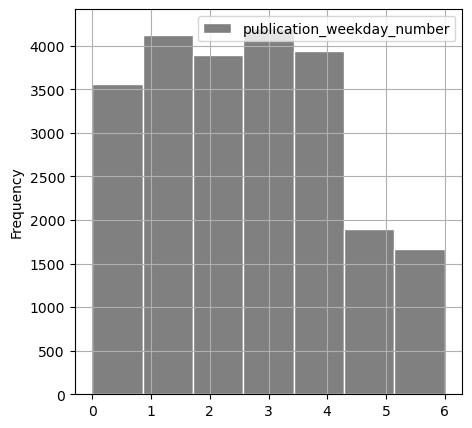

In [87]:
realty.plot(y='publication_weekday_number', kind='hist', bins=7, grid=True, range=(0, 6), figsize=(5, 5), color='gray', ec='white')
realty['publication_weekday_number'].describe().to_frame()


I guess the owners themselves post on weekends, that's why there are half as many adverts there, and both those and realtors on weekdays. Monday is a bit of a holiday for some.

##### Publication month

,publication_month
count,23276.000000
mean,6.404451
std,3.493646
min,1.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,12.000000


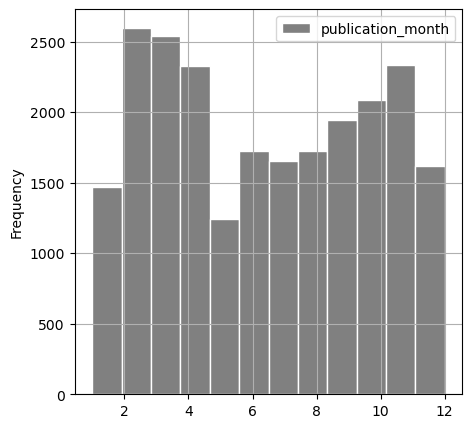

In [88]:
realty.plot(y='publication_month', kind='hist', bins=12, grid=True, figsize=(5, 5), color='gray', ec='white')
realty['publication_month'].describe().to_frame()

The hot season is February-March-April. May, summer and New Year holidays are notable. After summer until the new year, the number of adverts grows, but does not reach February. It makes sense.

#### Let's examine how rapidly flats have been sold

,days_exposition
count,20187.000000
mean,179.475708
std,218.142044
min,1.000000
25%,45.000000
50%,95.000000
75%,229.000000
max,1580.000000


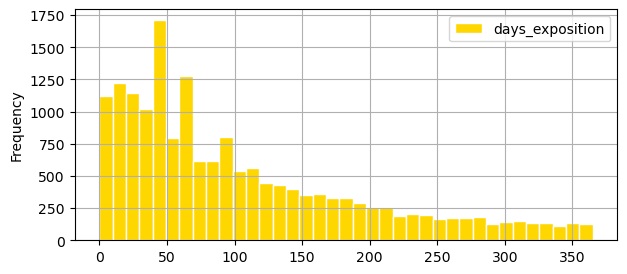

In [89]:
realty.plot(y='days_exposition', kind='hist', bins=37, grid=True, range=(0, 365), figsize=(7, 3), color='gold', ec='white')
realty['days_exposition'].describe().to_frame()

We see the average selling time is just under half a year, but the median is 95 days. Consequently, there are a lot of outliers (a lot of one-day listings, and there are also a few that have been hanging for almost 5 years). The outlier is about 4000 adverts at the 90 day level: google **Yandex real estate 45 days** - we get to the table in Yandex help, where it says about the rules of placing adverts:   
The key time periods are 45, 60 and 90 days. In our histogram we see drop-offs at 45 days, 60 days and on the 90th day.   
About 45 days they say that flats costing up to 4.5 million are automatically withdrawn from sale on that day, also about 60 and 90 days there are conditions when the ad is withdrawn.

In [90]:
'There are ' + str(len(realty['last_price'].loc[lambda x : x < 4.5])) + ' flats priced over 4.5 mln rubles'

'There are 11019 flats priced over 4.5 mln rubles'

**Summary:**  
We constructed a histogram where each column is about 10 days: we came up with a mean of 179 days and a median of 95 days. The large difference suggests a large number of anomalies. It looks like we have just over 11,000 announcements cheaper than 4.5 million rubles. In general, we can see that on average flats were sold in a month, then the graph drops down, that is, fewer and fewer flats were hanging longer.

### Which factors most affect the overall value of a property

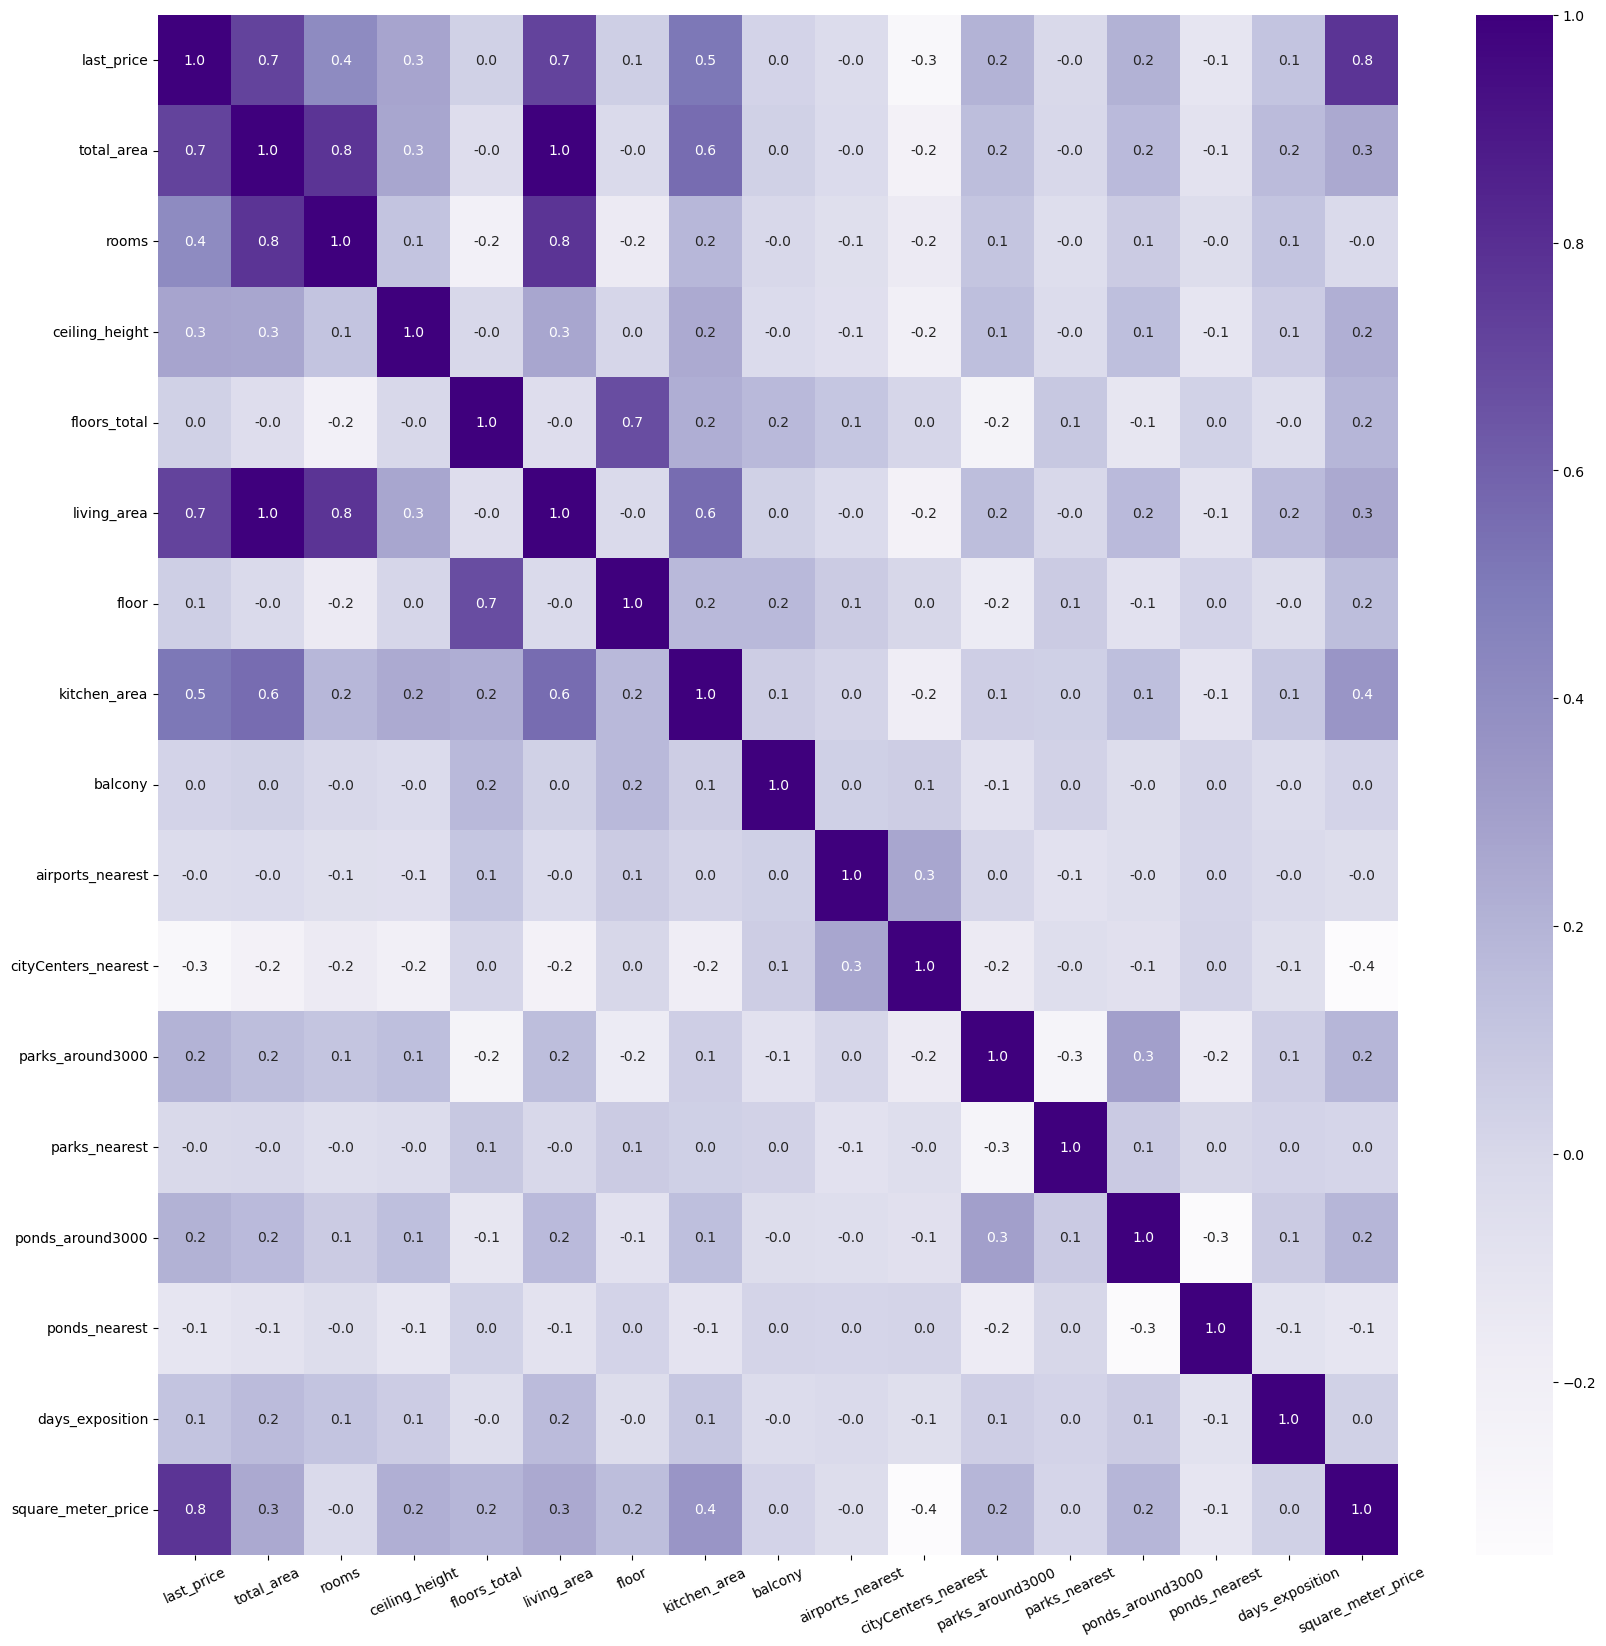

In [91]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(realty[['last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition', 'square_meter_price']].corr(), annot=True, cmap='Purples', fmt='.1f')
ax.set_xticklabels(ax.get_xticklabels(),rotation=25)
ax;

We look at the 'last price' line and we see:  
- large dependence on the column price per square metre, it is obvious,  
- dependence is logically increased in the columns of areas (total, living, kitchen),  
- number of rooms,  
- slightly lower, but there is from the proximity of parks and reservoirs,  
- interestingly, inverse dependence on the distance to the centre: we can assume that still elite housing in the centre is already less, all new buildings are now in dormitory areas, the demand for them more, the price of a renovated good flat is higher,  
- for the dependence on the type of floor and the day, month and year of publication the hitmap will not help, because these are **categorical variables**.

To find correlation by floor type, group by that value and find the average price and look at the bar chart.

floor_type
другой       6.243912
первый       4.593429
последний    5.652463
Name: last_price, dtype: float64


(array([0, 1, 2]),
 [Text(0, 0, 'другой'), Text(1, 0, 'первый'), Text(2, 0, 'последний')])

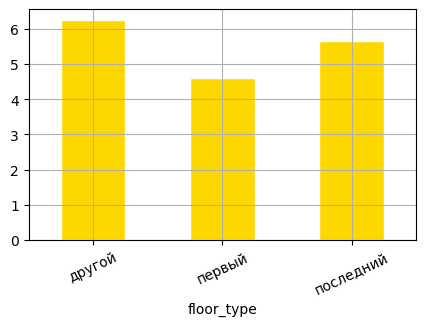

In [92]:
floor_type_for_hist = realty.groupby(['floor_type'])['last_price'].mean()
print(floor_type_for_hist) 

for name in floor_type_for_hist.index:   
    floor_type_for_hist.plot(y='last_price', kind='bar', grid=True, figsize=(5, 3), color='gold', ec='white')
plt.xticks(rotation=25)
    

publication_weekday_number
0    6.018019
1    5.963917
2    5.926663
3    6.185558
4    5.832202
5    5.863014
6    5.719226
Name: last_price, dtype: float64


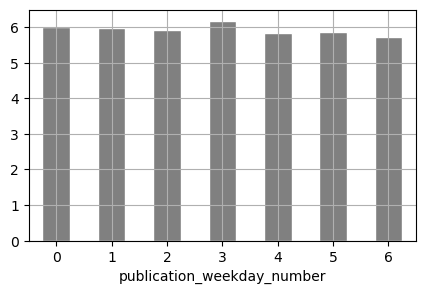

In [93]:
floor_type_for_hist = realty.groupby(['publication_weekday_number'])['last_price'].mean()
print(floor_type_for_hist) 

for name in floor_type_for_hist.index:   
    floor_type_for_hist.plot(y='last_price', kind='bar', grid=True, figsize=(5, 3), color='grey', ec='white')
plt.xticks(rotation=0);
    

publication_month
1     5.982356
2     6.018848
3     5.773408
4     5.953187
5     5.923996
6     5.813519
7     5.974638
8     5.973196
9     6.060844
10    5.828227
11    6.053291
12    6.188846
Name: last_price, dtype: float64


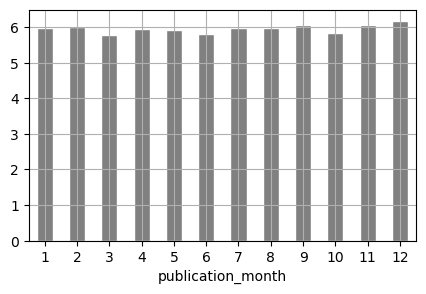

In [94]:
floor_type_for_hist = realty.groupby(['publication_month'])['last_price'].mean()
print(floor_type_for_hist) 

for name in floor_type_for_hist.index:   
    floor_type_for_hist.plot(y='last_price', kind='bar', grid=True, figsize=(5, 3), color='grey', ec='white')
plt.xticks(rotation=0);    

The dependence of the price on the day of the week and month of publication is almost unnoticeable.

### Let's calculate the average price per square metre in the 10 localities with the largest number of advertisements:

In [95]:
locality_minmax_price = realty.pivot_table(index = 'locality_name', values = 'square_meter_price', aggfunc=['count', 'mean'])
locality_minmax_price.columns = ['count', 'mean']
locality_minmax_price = locality_minmax_price.sort_values('count', ascending = False).head(10)
locality_minmax_price


,count,mean
locality_name,,
Санкт-Петербург,15380,113340.535046
посёлок Мурино,552,85629.114130
деревня Кудрово,470,95260.395745
посёлок Шушары,439,78550.883827
Всеволожск,398,68654.007538
Пушкин,363,103213.027548
Колпино,337,75332.869436
посёлок Парголово,326,90331.840491
Гатчина,307,68745.697068


Highlight max:

In [96]:
locality_minmax_price[locality_minmax_price['mean']==locality_minmax_price['mean'].max()]

,count,mean
locality_name,,
Санкт-Петербург,15380,113340.535046


Highlight min:

In [97]:
locality_minmax_price[locality_minmax_price['mean']==locality_minmax_price['mean'].min()]

,count,mean
locality_name,,
Выборг,237,58141.493671


The highest price per sq. metre (out of the top 10) is in St. Petersburg (Санкт-Петербург), the lowest - in Vyborg (Выборг).

Мisualise for clarity

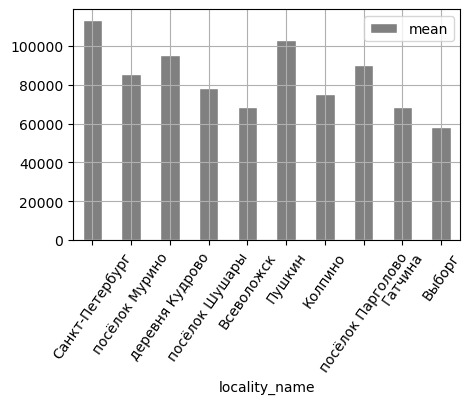

In [98]:
locality_minmax_price.plot(y='mean', kind='bar', grid=True, figsize=(5, 3), color='grey', ec='white')
plt.xticks(rotation=55);

### Let's highlight flats in St. Petersburg and watch the price change with distance from the centre:

Let's build a pivot table of price dependence on the distance to the centre, replacing blanks in the distance to the centre column in km by 500 to allow rounding.

In [99]:
realty['distance_to_centre_km'] = realty['distance_to_centre_km'].fillna(500)
#realty['distance_to_centre_km'] = realty['distance_to_centre_km'].astype('int')
realty['distance_to_centre_km'] = realty['distance_to_centre_km'].round()
spb_realty = realty.query('locality_name == "Санкт-Петербург" and 500 >= distance_to_centre_km >= 1')
spb_realty.pivot_table(index='distance_to_centre_km', values='square_meter_price').head(25)

,square_meter_price
distance_to_centre_km,
1.0,148906.053571
2.0,150485.812950
3.0,121650.329268
4.0,128272.896341
5.0,137465.593200
6.0,147940.363002
7.0,155059.514706
8.0,123890.168367
9.0,113015.484034


At this stage we see the dependence of the price per square metre on the distance to the centre. There are some exceptions, it may depend on the antiquity of the building, old flats are often untouched, therefore cheaper. In old houses there is less area, which affects the total cost. 
The sharpest gap in the price per square metre is observed between 7 and 8 km from the city centre. Therefore, we can consider that the centre of St. Petersburg is within the radius of 7 km.
We also see that after **10** km the price does not fall rapidly, which may indicate that there are new buildings, there are more of them, there is more competition, so the price per sq. m. does not vary much.

In [100]:
realty

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,publication_weekday_number,publication_month,publication_year,floor_type,distance_to_centre_km
0,20,13.000,108.000000,2019-03-07,3,2.70,16,62.639999,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой,16.0
1,7,3.350,40.400002,2018-12-04,1,2.75,11,23.431999,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый,19.0
2,10,5.196,56.000000,2015-08-20,2,2.55,5,32.480000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой,14.0
3,0,64.900,159.000000,2015-07-24,3,2.60,14,92.220001,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015,другой,7.0
4,2,10.000,100.000000,2018-06-19,2,3.03,14,58.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9.700,133.809998,2017-03-21,3,3.70,5,77.609802,3,False,False,False,13.830000,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,72490,1,3,2017,другой,4.0
23695,14,3.100,59.000000,2018-01-15,3,2.55,5,34.220001,4,False,False,False,8.500000,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,52542,0,1,2018,другой,500.0
23696,18,2.500,56.700001,2018-02-11,2,2.80,3,32.886002,1,False,False,False,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44091,6,2,2018,первый,500.0
23697,13,11.475,76.750000,2017-03-28,2,3.00,17,44.514999,12,False,False,False,23.299999,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,149511,1,3,2017,другой,10.0


In [101]:
realty.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,publication_weekday_number,publication_month,publication_year,distance_to_centre_km
count,23276.000000,23276.000000,23276.000000,23276,23276.000000,23276.000000,23276.000000,23276.000000,23276.000000,21087.000000,23276.000000,17762.000000,17782.000000,17783.000000,7835.000000,17783.000000,8834.000000,20187.000000,23276.000000,23276.000000,23276.000000,23276.000000,23276.000000
mean,9.850919,5.958051,57.801876,2017-11-10 17:49:02.979893248,2.019333,2.705346,10.729034,33.525089,5.893152,10.282082,0.596752,28840.023438,14313.312500,0.601136,492.297119,0.760951,521.093262,179.475708,98229.951796,2.566549,6.404451,2017.371799,128.948151
min,0.000000,0.012190,12.000000,2014-11-27 00:00:00,0.000000,1.000000,1.000000,6.960000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,111.000000,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000,40.000000,2017-05-16 00:00:00,1.000000,2.550000,5.000000,23.200001,2.000000,7.000000,0.000000,18488.500000,9487.000000,0.000000,288.000000,0.000000,297.250000,45.000000,76470.000000,1.000000,3.000000,2017.000000,11.000000
50%,9.000000,4.600000,51.500000,2017-12-13 00:00:00,2.000000,2.650000,9.000000,29.870001,4.000000,9.000000,0.000000,26890.000000,13168.000000,0.000000,456.000000,0.000000,505.500000,95.000000,94829.500000,3.000000,6.000000,2017.000000,15.000000
75%,14.000000,6.650000,68.300003,2018-08-27 00:00:00,3.000000,2.750000,16.000000,39.613998,8.000000,11.800000,1.000000,37406.750000,16324.250000,1.000000,614.000000,1.000000,733.000000,229.000000,113861.000000,4.000000,10.000000,2018.000000,36.000000
max,50.000000,135.000000,200.000000,2019-05-03 00:00:00,5.000000,22.600000,60.000000,116.000000,33.000000,50.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,995983.000000,6.000000,12.000000,2019.000000,500.000000
std,5.662171,5.514729,25.819941,NaN,0.960426,0.315003,6.605651,14.975625,4.883446,4.982358,0.961897,12693.577148,8588.529297,0.792360,343.008209,0.933646,277.844360,218.142044,43277.899164,1.789598,3.493646,1.036860,206.381638


### General summary:

We did a lot of work: we got a spreadsheet with various manual typos, incorrect data types, missing values, and values that were not sufficient to fulfil our tasks. By logical reasoning, we filled in the blanks where possible, corrected typos, removed anomalies added data and got answers to the questions posed.
Interesting patterns of price per square metre of area were detected, the information is given conveniently, in tables and graphically. The general conclusion on property sales in St. Petersburg is as follows:

The most common adverts where:
- the average area of flats for sale is about 50 square metres,
- the average living area is slightly less than 30 square metres. m,
- the area of the kitchen 9 square metres,
- average cost of 4.6 million rubles,
- 2 rooms,
- height of the ceiling 2.65 m,
- apartment on the 4th floor in a 9-storey building,
- 13 km to the centre,
- parks and ponds in walking distance.

It was also found that flat ads are hard work, so most likely working people post their property on weekends, and realtors work all week. It has been noticed that the placement of adverts is subject to generally accepted holidays and vacations (summer, New Year).
It is quite difficult to judge the time of placing an announcement, because Yandex.Real Estate has rules that remove ads on certain days.
We found that the cost of the object is affected by the area (total, living, kitchen), number of rooms, proximity of parks and water bodies, although this information is not very full. The ground floor has always been and remains the cheapest, then the last floor, then all the others.
Also be sure to send information about missing values and typos to colleagues to make it so that there are fewer of them.
Very interesting project, a lot can be learnt, calculated, found out from standard data.